## Import all libraries

In [1]:
import os, sys
import time
# set the working directory
sys.path.append(os.getcwd()+ "\..\..")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pycaret.classification as pc
import seaborn as sns
from imblearn.over_sampling import SMOTEN, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn import preprocessing
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# import from ../script/data.py in scripts folder
from src.scripts.data import CR8_smoke_dict, OR45_dict 
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

define some functions

In [2]:
def read_dataframes(folder_path):
    file_list = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    file_list = file_list[2:]
    dataframes = {file: pd.read_csv(os.path.join(folder_path, file)) for file in file_list}
    return dataframes


def get_common_columns(dataframes):
    common_columns = dataframes[list(dataframes.keys())[0]].columns
    for df in dataframes.values():
        common_columns = common_columns.intersection(df.columns)
    return common_columns


def preprocess_dataframes(dataframes, common_columns):
    merged_df = pd.DataFrame()
    for i, (file, df) in enumerate(dataframes.items()):
        df = df[common_columns]
        # df.insert(0, "State", file.split(" ")[2])
        df.insert(0, "State", i)
        merged_df = pd.concat([merged_df, df])
    return merged_df


Import and preprocess data

In [19]:

# Read dataframes from GYTS folder
dataframes = read_dataframes("../../data/raw/GYTS/")

# Find common columns in all dataframes
common_columns = get_common_columns(dataframes)

# Preprocess dataframes
merged_df = preprocess_dataframes(dataframes, common_columns)


# Rename columns
merged_df.rename(columns={"CR1": "Age"}, inplace=True)
merged_df.rename(columns={"CR2": "Gender"}, inplace=True)
merged_df["CR8"] = merged_df["CR8"].map(CR8_smoke_dict)
merged_df.rename(columns={"CR8": "Smoke"}, inplace=True)
merged_df.rename(columns={"OR45": "SmokingParents"}, inplace=True)
merged_df.rename(columns={"OR46": "SmokingFriends"}, inplace=True)
merged_df.rename(columns={"OR1": "WorkingParents"}, inplace=True)
merged_df.rename(columns={"CR22": "SeenSmokerInSchool"}, inplace=True)
merged_df.rename(columns={"CR21": "SeenSmokerInPublicPlace"}, inplace=True)
merged_df.rename(columns={"CR20": "SeenSmokerInEnclosedPlace"}, inplace=True)
merged_df.rename(columns={"CR19": "SeenSmokerInHome"}, inplace=True)
merged_df.rename(columns={"CR5": "TriedCigarette"}, inplace=True)
merged_df.rename(columns={"CR6": "AgeFirstCigarette"}, inplace=True)


# Keep only the desired columns
# merged_df = merged_df[["State", "Gender", "Age", "Smoke", "SmokingParents", "SmokingFriends", "WorkingParents",
#                        "SeenSmokerInSchool", "SeenSmokerInPublicPlace", "SeenSmokerInEnclosedPlace",
#                        "SeenSmokerInHome", "TriedCigarette", "AgeFirstCigarette"]]
merged_df = merged_df[["State", "Gender", "Age", "Smoke", "SmokingParents", "SmokingFriends", "WorkingParents",
                       "SeenSmokerInSchool", "SeenSmokerInPublicPlace", "SeenSmokerInEnclosedPlace",
                       "SeenSmokerInHome"]]
# merged_df = merged_df[["State", "Gender", "Age", "Smoke", "SmokingParents", "SmokingFriends", "WorkingParents"]]

# Drop rows with missing values
merged_df = merged_df.dropna()

merged_df['SmokingFather'] = merged_df['SmokingParents'].apply(lambda x: True if OR45_dict[x] in ['Both', 'Father only'] else False)
merged_df['SmokingMother'] = merged_df['SmokingParents'].apply(lambda x: True if OR45_dict[x] in ['Both', 'Mother only'] else False)
merged_df = merged_df.drop(columns=['SmokingParents'])

# Convert columns to categorical
merged_df['State'] = merged_df['State'].astype('int').astype('category')
merged_df["Gender"] = merged_df["Gender"].astype('int').astype('category')
merged_df["Age"] = merged_df["Age"].astype('int').astype('category')
merged_df["Smoke"] = merged_df["Smoke"].astype('int').astype('category')
#merged_df["SmokingParents"] = merged_df["SmokingParents"].astype('int').astype('category')
merged_df["SmokingFriends"] = merged_df["SmokingFriends"].astype('int').astype('category')
merged_df["WorkingParents"] = merged_df["WorkingParents"].astype('int').astype('category')
merged_df["SeenSmokerInSchool"] = merged_df["SeenSmokerInSchool"].astype('int').astype('category')
merged_df["SeenSmokerInPublicPlace"] = merged_df["SeenSmokerInPublicPlace"].astype('int').astype('category')
merged_df["SeenSmokerInEnclosedPlace"] = merged_df["SeenSmokerInEnclosedPlace"].astype('int').astype('category')
merged_df["SeenSmokerInHome"] = merged_df["SeenSmokerInHome"].astype('int').astype('category')
# merged_df["TriedCigarette"] = merged_df["TriedCigarette"].astype('category')
# merged_df["AgeFirstCigarette"] = merged_df["AgeFirstCigarette"].astype('category')

# Convert to boolean
merged_df['SmokingFather'] = merged_df['SmokingFather'].astype('bool')
merged_df['SmokingMother'] = merged_df['SmokingMother'].astype('bool')

# Save the preprocessed dataframe to a CSV file
merged_df.to_csv("../../data/processed/merged_GYTS.csv", index=False)

merged_df

,State,Gender,Age,Smoke,SmokingFriends,WorkingParents,SeenSmokerInSchool,SeenSmokerInPublicPlace,SeenSmokerInEnclosedPlace,SeenSmokerInHome,SmokingFather,SmokingMother
49,0,2,5,1,1,2,2,2,2,1,True,True
51,0,2,5,1,2,3,2,2,2,1,False,False
55,0,1,4,0,1,2,2,3,2,1,True,True
111,0,2,5,1,2,2,2,3,2,1,True,True
122,0,1,4,1,2,3,2,3,2,2,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...
1674,3,2,3,0,3,3,2,5,1,1,False,False
1675,3,2,3,0,2,3,2,3,1,2,False,False
1677,3,1,3,0,4,3,1,3,2,2,False,False
1678,3,1,3,0,2,3,1,1,1,2,True,False


Train and test model

In [41]:
# # Correlation matrix
# corr = merged_df_encoded.corr()
# fig, ax = plt.subplots(figsize=(40, 30))
# sns.heatmap(corr, annot=True, annot_kws={"size": 8}, linewidths=.5, ax=ax)
# plt.savefig("./data/processed/correlation_matrix.svg")
# # plt.show()

# Split the data into train and test sets
train, test = train_test_split(merged_df, test_size=0.2, random_state=42)
test.reset_index(drop=True, inplace=True)

# Split the train set into features and target
X = train.drop(columns=["Smoke"])
y = train["Smoke"]

# Convert y values to categorical values
lab = preprocessing.LabelEncoder()
y = lab.fit_transform(y)

No Sampling

In [40]:
y = pd.DataFrame(y, columns=["Smoke"])
y.reset_index(drop=True, inplace=True)
X.reset_index(drop=True, inplace=True)
train = pd.concat([X, y] , axis=1)

Sampling

In [42]:
# SMOTE Oversampling
# smote = SMOTEN()
# smote = ADASYN()
smote = RandomUnderSampler()
X_resampled, y_resampled = smote.fit_resample(X, y)

# Convert array to dataframe
y_resampled = pd.DataFrame(y_resampled, columns=['Smoke'])
# y = pd.DataFrame(y, columns=['Smoke'])

# remove index
# X.reset_index(drop=True, inplace=True)
# y.reset_index(drop=True, inplace=True)
X_resampled.reset_index(drop=True, inplace=True)

train = pd.concat([X_resampled, y_resampled], axis=1)
# df_resampled = pd.concat([X, y], axis=1)

Comparing models

In [43]:
setup = pc.setup(data=train,
                      target='Smoke',
                      session_id=123,
                      normalize=True,
                      transformation=True,
                      remove_multicollinearity=True, multicollinearity_threshold=0.95, max_encoding_ohe=0)

pc.compare_models()

,Description,Value
0,Session id,123
1,Target,Smoke
2,Target type,Binary
3,Original data shape,"(4062, 12)"
4,Transformed data shape,"(4062, 12)"
5,Transformed train set shape,"(2843, 12)"
6,Transformed test set shape,"(1219, 12)"
7,Categorical features,9
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.7703,0.0000,0.7890,0.7608,0.7745,0.5406,0.5412,0.0330
ada,Ada Boost Classifier,0.7703,0.5861,0.7813,0.7650,0.7726,0.5406,0.5414,0.0680
lda,Linear Discriminant Analysis,0.7703,0.8304,0.7890,0.7608,0.7745,0.5406,0.5412,0.0350
gbc,Gradient Boosting Classifier,0.7699,0.6493,0.8031,0.7537,0.7771,0.5399,0.5420,0.0740
lr,Logistic Regression,0.7696,0.8304,0.7862,0.7612,0.7734,0.5392,0.5397,0.0360
qda,Quadratic Discriminant Analysis,0.7615,0.4385,0.7940,0.7461,0.7689,0.5230,0.5248,0.0350
lightgbm,Light Gradient Boosting Machine,0.7587,0.5869,0.7946,0.7426,0.7668,0.5174,0.5203,0.1600
nb,Naive Bayes,0.7576,0.4315,0.7637,0.7552,0.7592,0.5153,0.5156,0.0350
rf,Random Forest Classifier,0.7534,0.6532,0.7904,0.7362,0.7617,0.5068,0.5094,0.1020
svm,SVM - Linear Kernel,0.7510,0.0000,0.7651,0.7455,0.7538,0.5019,0.5040,0.0310


RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, positive=False, random_state=123, solver='auto',
                tol=0.0001)

Choosing best model

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8000,0.0000,0.8252,0.7867,0.8055,0.5999,0.6007
1,0.7544,0.0000,0.7902,0.7386,0.7635,0.5086,0.5099
2,0.8000,0.0000,0.8380,0.7778,0.8068,0.6001,0.6019
3,0.7923,0.0000,0.7887,0.7943,0.7915,0.5845,0.5845
4,0.7711,0.0000,0.7746,0.7692,0.7719,0.5423,0.5423
5,0.7183,0.0000,0.7324,0.7123,0.7222,0.4366,0.4368
6,0.7746,0.0000,0.7817,0.7708,0.7762,0.5493,0.5494
7,0.7570,0.0000,0.7676,0.7517,0.7596,0.5141,0.5142
8,0.7676,0.0000,0.7958,0.7533,0.7740,0.5352,0.5361


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

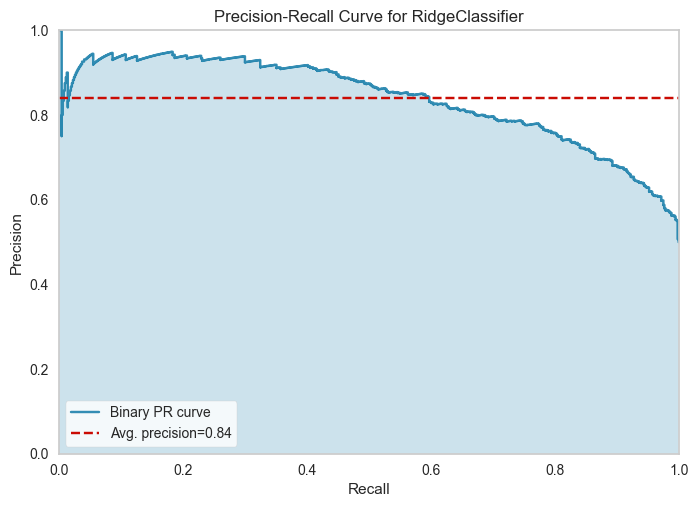

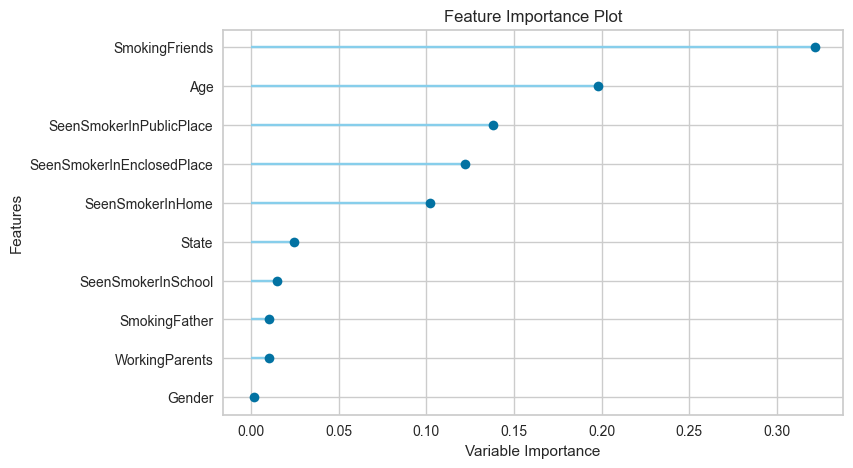

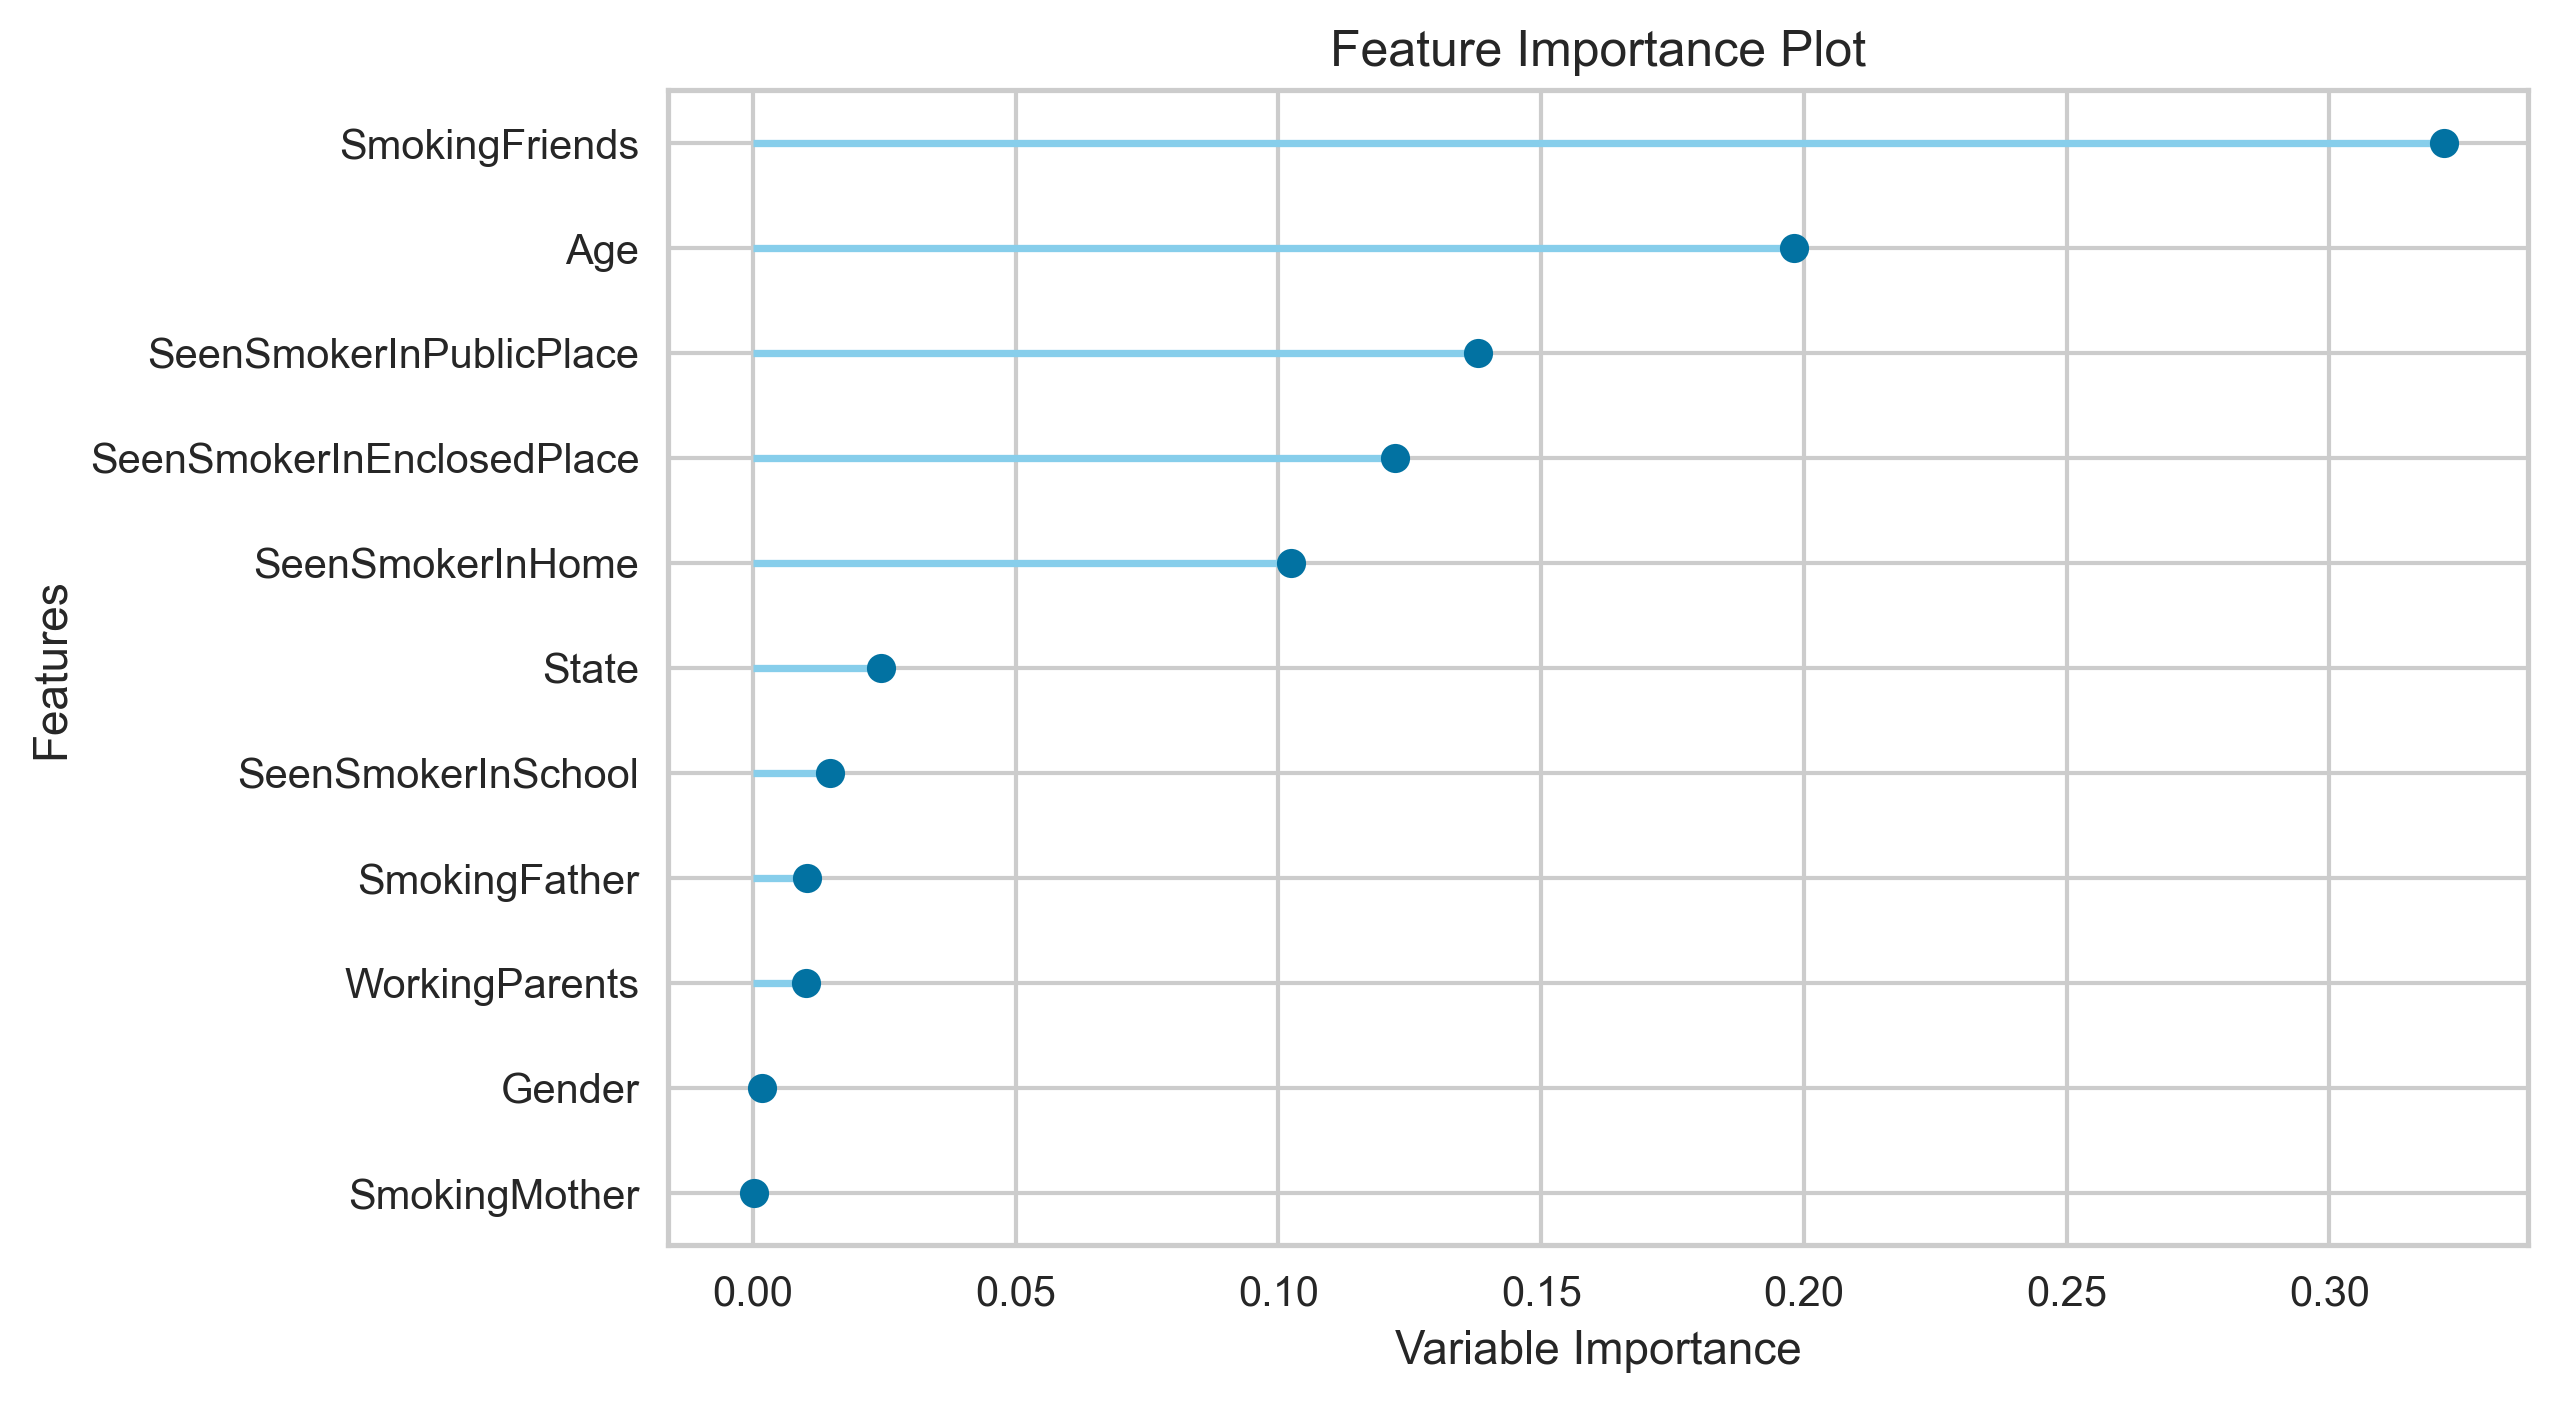

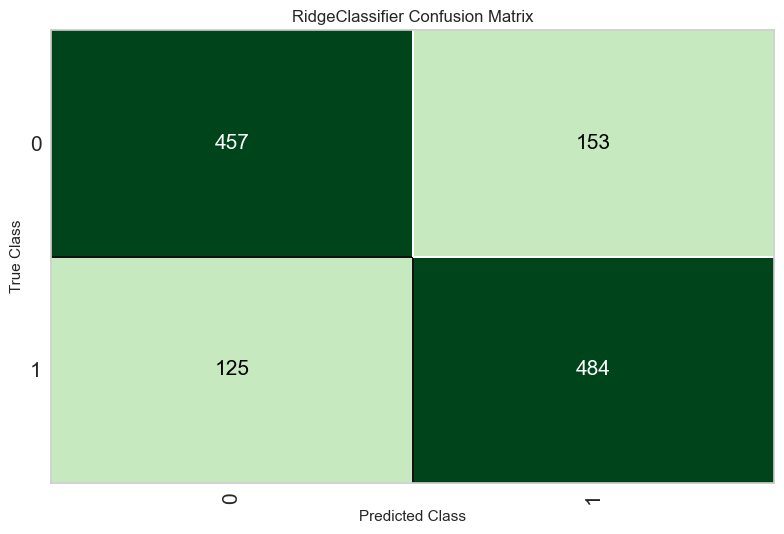

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ridge Classifier,0.7769,0.7769,0.8046,0.7621,0.7827,0.5538,0.5546


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ridge Classifier,0.7599,0.7653,0.7723,0.3006,0.4327,0.3160,0.3726


  State Gender Age SmokingFriends WorkingParents SeenSmokerInSchool  \
0     0      2   5              2              4                  2   
1     2      1   3              1              3                  2   
2     2      2   3              1              3                  1   
3     0      1   6              3              3                  1   
4     2      1   3              1              1                  1   

  SeenSmokerInPublicPlace SeenSmokerInEnclosedPlace SeenSmokerInHome  \
0                       4                         3                1   
1                       1                         1                1   
2                       2                         1                1   
3                       4                         4                1   
4                       1                         1                1   

   SmokingFather  SmokingMother Smoke  prediction_label  
0           True          False     1                 1  
1          False        

In [46]:
# Extra Trees Classifier
model = pc.create_model('ridge')


# pc.plot_model(model, plot='auc')
pc.plot_model(model, plot='pr')
pc.plot_model(model, plot='feature')
pc.plot_model(model, plot='feature_all',scale=3)
pc.plot_model(model, plot='confusion_matrix')

final_rf = pc.finalize_model(model)
# final_rf
pc.predict_model(final_rf)
# print(final_rf)

unseen_predictions = pc.predict_model(final_rf, data=test)
print(unseen_predictions.head())

In [48]:
# model = ExtraTreesClassifier(model)

pd.DataFrame({'Feature': pc.get_config('X_train').columns, 'Value' : abs(model.feature_importances_)}).sort_values(by='Value', ascending=False)

AttributeError: 'RidgeClassifier' object has no attribute 'feature_importances_'

In [ ]:
pc.interpret_model(model, plot='summary')